In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
dev_data_path = '/content/drive/MyDrive/Convolve/Dev_data_to_be_shared.csv'
validation_data_path = '/content/drive/MyDrive/Convolve/validation_data_to_be_shared.csv'

dev_data_df = pd.read_csv(dev_data_path)
validation_data_df = pd.read_csv(validation_data_path)


In [4]:
print("Dev Data:")
dev_data_df.head()


Dev Data:


,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,221000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,86000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,215000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print("\nValidation Data:")
validation_data_df.head()



Validation Data:


,account_number,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,transaction_attribute_8,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,100001,34000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,130000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,53000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print(dev_data_df.isnull().sum())
print(validation_data_df.isnull().sum())

account_number                 0
bad_flag                       0
onus_attribute_1           25231
transaction_attribute_1    25231
transaction_attribute_2    25231
                           ...  
onus_attribute_44          85196
onus_attribute_45          85196
onus_attribute_46          85196
onus_attribute_47          85196
onus_attribute_48          85196
Length: 1216, dtype: int64
account_number                 0
onus_attribute_1           10990
transaction_attribute_1    10990
transaction_attribute_2    10990
transaction_attribute_3    10990
                           ...  
onus_attribute_44          36789
onus_attribute_45          36789
onus_attribute_46          36789
onus_attribute_47          36789
onus_attribute_48          36789
Length: 1215, dtype: int64


<ipython-input-9-2307b038e044>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dev_data_df[col].fillna(median_value, inplace=True)
<ipython-input-9-2307b038e044>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

Number of rows with bad_flag=1: 1372
Clustering on 1214 numeric features.
     account_number  cluster_label
141             142              0
246             247              0
289             290              0
351             352              0
476             477              0
Cluster Centers (in scaled feature space):
[[ 0.00913633  0.00275496  0.00275496 ...  0.00290401 -0.01433731
  -0.01433731]
 [-0.9485115  -0.02700731 -0.02700731 ... -0.20622343 -0.07221387
  -0.07221387]
 [-0.08274777 -0.02700731 -0.02700731 ... -0.02705768  0.14223944
   0.14223944]]
Cluster Centers (in original feature space):
[[ 1.03587952e+05  6.42570281e-01  8.03212851e-04 ...  1.27791165e+00
   6.42570281e-03  6.42570281e-03]
 [ 2.50000000e+04  0.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 9.60476190e+04 -9.99200722e-16 -1.08420217e-18 ...  1.23809524e+00
   2.38095238e-02  2.38095238e-02]]


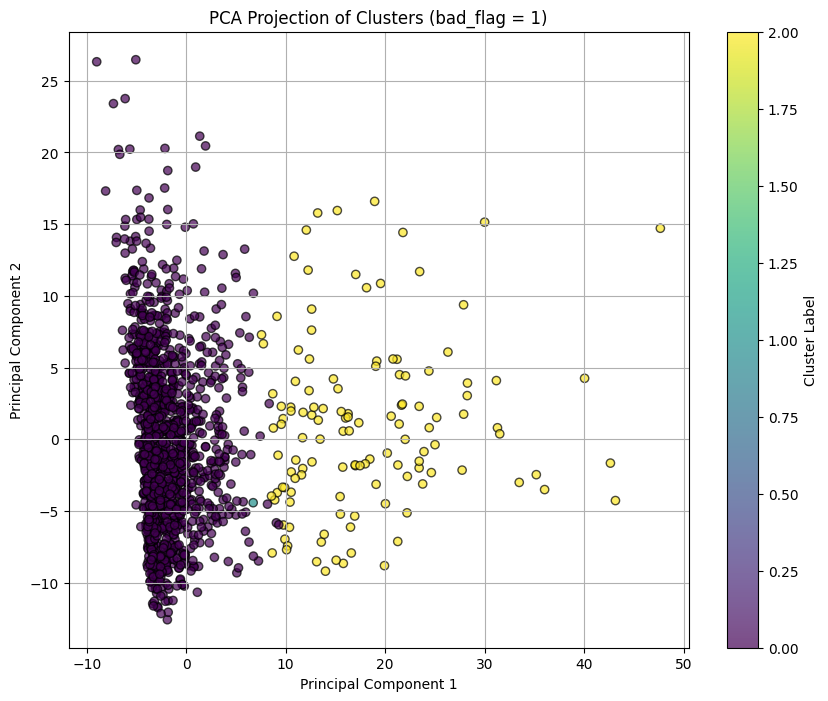

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Separate columns by their prefixes
transaction_cols = [col for col in dev_data_df.columns if col.startswith("transaction_attribute")]
onus_cols = [col for col in dev_data_df.columns if col.startswith("onus_attribute")]
bureau_enquiry_cols = [col for col in dev_data_df.columns if col.startswith("bureau_enquiry")]
bureau_cols = [col for col in dev_data_df.columns if col.startswith("bureau")]

# Impute transaction_attribute_# columns with 0
dev_data_df[transaction_cols] = dev_data_df[transaction_cols].fillna(0)
validation_data_df[transaction_cols] = validation_data_df[transaction_cols].fillna(0)

# Impute onus_attributes with median (NaN only)
for col in onus_cols:
    median_value = dev_data_df[col].median()  # Calculate median (NaN values not included)
    dev_data_df[col].fillna(median_value, inplace=True)
    validation_data_df[col].fillna(median_value, inplace=True)

# Impute bureau attributes with mean (NaN only)
for col in bureau_cols:
    mean_value = dev_data_df[col].mean()  # Calculate mean (NaN values not included)
    dev_data_df[col].fillna(mean_value, inplace=True)
    validation_data_df[col].fillna(mean_value, inplace=True)

# Impute bureau_enquiry attributes with median (NaN only)
for col in bureau_enquiry_cols:
    median_value = dev_data_df[col].median()  # Calculate median (NaN values not included)
    dev_data_df[col].fillna(median_value, inplace=True)
    validation_data_df[col].fillna(median_value, inplace=True)

dev_data_df.fillna(0, inplace=True)
validation_data_df.fillna(0, inplace=True)

# Assuming dev_data_df is already loaded, cleaned, and you have computed sum_mod_1 and sum_mod_3 as before.
# Also assuming you want to include these newly computed sums as features.

###############################################################################
# 1. Subset Rows where bad_flag = 1
###############################################################################
bad_subset = dev_data_df[dev_data_df['bad_flag'] == 1].copy()
print(f"Number of rows with bad_flag=1: {len(bad_subset)}")

###############################################################################
# 2. Select All Relevant Feature Columns for Clustering
###############################################################################
# Drop identifier columns and the target flag, since they are not features for clustering.
# Adjust this list if you have other non-feature columns.
features = bad_subset.drop(columns=['account_number', 'bad_flag'])

# Optionally, you can further filter out non-numeric columns:
numeric_features = features.select_dtypes(include=[np.number])

print(f"Clustering on {numeric_features.shape[1]} numeric features.")

###############################################################################
# 3. (Optional) Scale Features
###############################################################################
# Scaling is recommended when features have different scales.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_features)

###############################################################################
# 4. Apply K-Means Clustering
###############################################################################
# Choose a number of clusters; for demonstration, we'll pick 3.
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Assign cluster labels to each row in the bad_subset
bad_subset['cluster_label'] = kmeans.labels_

###############################################################################
# 5. Examine Clustering Results
###############################################################################
# Show first few rows with cluster assignments
print(bad_subset[['account_number', 'cluster_label']].head())

# Optionally, view the cluster centers in the scaled feature space
print("Cluster Centers (in scaled feature space):")
print(kmeans.cluster_centers_)

# If you wish to see cluster centers in the original feature space:
original_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers (in original feature space):")
print(original_centers)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Assumptions:
# dev_data_df: DataFrame with all data and a 'bad_flag' column.
# X_scaled: Scaled features for all rows in dev_data_df.
# bad_subset: DataFrame for rows with bad_flag=1, containing a 'cluster_label' column.
# ---

# 1. Filter for rows where bad_flag = 1
bad_filter = dev_data_df['bad_flag'] == 1

# Extract cluster labels corresponding to these rows
# Ensure alignment between bad_subset and the filtered indices
cluster_labels = bad_subset['cluster_label'].values

# 2. Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 3. Create a scatter plot of the first two principal components, colored by cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, edgecolor='k')
plt.title('PCA Projection of Clusters (bad_flag = 1)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()



# Implementation 2: Using Simple Feed Forward Neural Network with Advanced Techniques

(Implementation 1 given below)

<ipython-input-10-5183c1b88663>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dev_data_df[col].fillna(median_value, inplace=True)
<ipython-input-10-5183c1b88663>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

Feature Importance Ranking:

onus_attribute_2: 0.0111
onus_attribute_17: 0.0102
bureau_439: 0.0087
bureau_442: 0.0076
bureau_441: 0.0075
bureau_452: 0.0074
bureau_429: 0.0073
bureau_43: 0.0070
bureau_432: 0.0070
bureau_428: 0.0068
bureau_59: 0.0066
bureau_431: 0.0065
bureau_397: 0.0065
bureau_125: 0.0064
bureau_415: 0.0063
bureau_62: 0.0063
bureau_66: 0.0062
bureau_52: 0.0060
bureau_64: 0.0058
bureau_enquiry_31: 0.0057
bureau_395: 0.0057
bureau_445: 0.0057
bureau_426: 0.0056
bureau_42: 0.0056
bureau_434: 0.0055
bureau_65: 0.0055
bureau_51: 0.0054
bureau_9: 0.0054
bureau_421: 0.0053
bureau_137: 0.0053


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Original training distribution:
bad_flag
0    76346
1     1098
Name: count, dtype: int64

SMOTE training distribution:
bad_flag
0    76346
1     3817
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - AUC: 0.6953 - accuracy: 0.5551 - loss: 0.6939 - val_AUC: 0.8260 - val_accuracy: 0.6613 - val_loss: 0.5282
Epoch 2/20
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.8198 - accuracy: 0.6879 - loss: 0.5399 - val_AUC: 0.8297 - val_accuracy: 0.7290 - val_loss: 0.4486
Epoch 3/20
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8439 - accuracy: 0.7206 - loss: 0.4979 - val_AUC: 0.8341 - val_accuracy: 0.7355 - val_loss: 0.5644
Epoch 4/20
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8575 - accuracy: 0.7283 - loss: 0.4829 - val_AUC: 0.8308 - val_accuracy: 0.7602 - val_loss: 0.7356
Epoch 5/20
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8778 - accuracy: 0.7393 - loss: 0.4559 - val_AUC: 0.8213 - val_accuracy: 0.7547 - val_loss: 0.9201
Epoch 6/20
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.8834 - accuracy: 0.7477 - loss: 0.4460 - val_AUC: 0.8225 - val_accuracy: 0.7689 - val_loss: 0.8398
Epoch 7/20
2506/2506 ━━━━

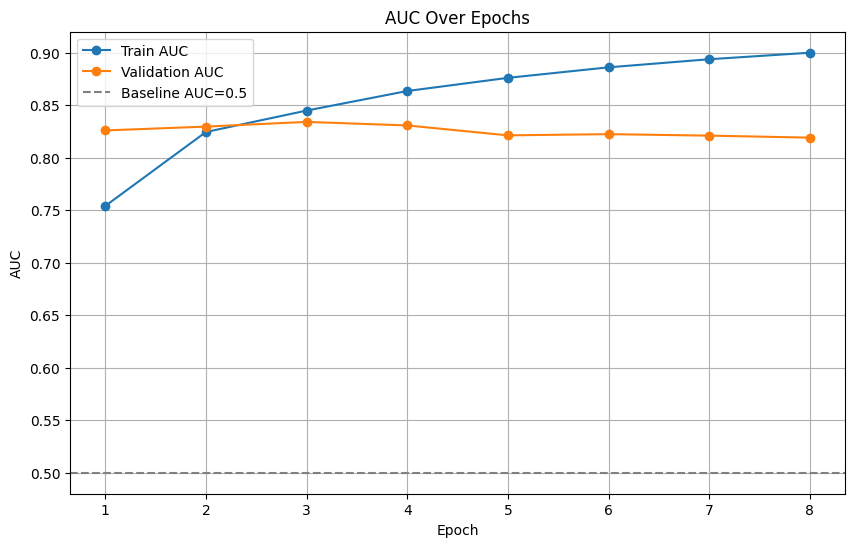

606/606 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Holdout AUC: 0.8339
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


<ipython-input-10-5183c1b88663>:212: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  validation_data_df['predicted_probability'] = val_probs


In [10]:
# Separate columns by their prefixes
transaction_cols = [col for col in dev_data_df.columns if col.startswith("transaction_attribute")]
onus_cols = [col for col in dev_data_df.columns if col.startswith("onus_attribute")]
bureau_enquiry_cols = [col for col in dev_data_df.columns if col.startswith("bureau_enquiry")]
bureau_cols = [col for col in dev_data_df.columns if col.startswith("bureau")]

# Impute transaction_attribute_# columns with 0
dev_data_df[transaction_cols] = dev_data_df[transaction_cols].fillna(0)
validation_data_df[transaction_cols] = validation_data_df[transaction_cols].fillna(0)

# Impute onus_attributes with median (NaN only)
for col in onus_cols:
    median_value = dev_data_df[col].median()  # Calculate median (NaN values not included)
    dev_data_df[col].fillna(median_value, inplace=True)
    validation_data_df[col].fillna(median_value, inplace=True)

# Impute bureau attributes with mean (NaN only)
for col in bureau_cols:
    mean_value = dev_data_df[col].mean()  # Calculate mean (NaN values not included)
    dev_data_df[col].fillna(mean_value, inplace=True)
    validation_data_df[col].fillna(mean_value, inplace=True)

# Impute bureau_enquiry attributes with median (NaN only)
for col in bureau_enquiry_cols:
    median_value = dev_data_df[col].median()  # Calculate median (NaN values not included)
    dev_data_df[col].fillna(median_value, inplace=True)
    validation_data_df[col].fillna(median_value, inplace=True)

dev_data_df.fillna(0, inplace=True)
validation_data_df.fillna(0, inplace=True)


###############################################################################
# 3. SPLIT FEATURES & TARGET (DEVELOPMENT DATA)
###############################################################################
X_dev = dev_data_df.drop(columns=['account_number', 'bad_flag'])
y_dev = dev_data_df['bad_flag']

###############################################################################
# 4. LOW-VARIANCE FEATURE REMOVAL
###############################################################################
lv_thresh = VarianceThreshold(threshold=0.0)
X_dev_lv = lv_thresh.fit_transform(X_dev)
kept_cols_lv = X_dev.columns[lv_thresh.get_support()]

###############################################################################
# 5. CORRELATION-BASED PRUNING
###############################################################################
X_dev_lv_df = pd.DataFrame(X_dev_lv, columns=kept_cols_lv)
corr_matrix = X_dev_lv_df.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

corr_threshold = 0.90
to_drop = [
    col for col in upper.columns if any(upper[col] > corr_threshold)
]

kept_cols_corr = [col for col in X_dev_lv_df.columns if col not in to_drop]
X_dev_corr = X_dev_lv_df[kept_cols_corr].values  # final numeric matrix

###############################################################################
# 5.5. RANDOM FOREST FEATURE IMPORTANCE CHECK
###############################################################################
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_dev_corr, y_dev)  # train on entire dev set for quick check
importances = rf.feature_importances_

# Sort from most to least important
indices = np.argsort(importances)[::-1]

print("Feature Importance Ranking:\n")
for idx in indices[:30]:  # printing top 30
    print(f"{kept_cols_corr[idx]}: {importances[idx]:.4f}")

###############################################################################
# 6. TRAIN-TEST SPLIT (STRATIFIED) ON REDUCED FEATURES
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(
    X_dev_corr, y_dev,
    test_size=0.2,
    random_state=42,
    stratify=y_dev
)

###############################################################################
# 7. SCALING
###############################################################################
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# We'll scale validation data later using same scaler:
# X_val_scaled = scaler.transform(X_val_corr)  (done before submission)

###############################################################################
# 8. SMOTE OVERSAMPLING (TRAIN SET ONLY)
###############################################################################
# We do SMOTE after scaling, but you can also do it before scaling.
# We'll do it here after scaling for demonstration.
# sampling_strategy=0.05 => minority class will be 5% of majority class size
sm = SMOTE(sampling_strategy=0.05, random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

print("Original training distribution:")
print(y_train.value_counts())
print("\nSMOTE training distribution:")
print(pd.Series(y_train_sm).value_counts())

###############################################################################
# 9. CLASS WEIGHTS
###############################################################################
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_sm),
    y=y_train_sm
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

###############################################################################
# 10. DEFINE THE MODEL (WITH L2 REGULARIZATION & INCREASED DROPOUT)
###############################################################################
model = Sequential([
    Dense(32, activation='relu', input_dim=X_train_sm.shape[1], kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    Dense(16, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')]
)

###############################################################################
# 11. EARLY STOPPING
###############################################################################
early_stop = EarlyStopping(
    monitor='val_AUC',  # or 'val_loss'
    mode='max',         # because we want to maximize AUC
    patience=5,         # stop if no improvement for 5 consecutive epochs
    restore_best_weights=True  # revert to best epoch
)

###############################################################################
# 12. TRAINING
###############################################################################
history = model.fit(
    X_train_sm,
    y_train_sm,
    validation_data=(X_test_scaled, y_test),
    epochs=20,           # big upper bound, early stopping typically stops earlier
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

import matplotlib.pyplot as plt

# Check if AUC and val_AUC are in history
if 'AUC' in history.history and 'val_AUC' in history.history:
    epochs = range(1, len(history.history['AUC']) + 1)
    plt.figure(figsize=(10, 6))

    # Plot training and validation AUC
    plt.plot(epochs, history.history['AUC'], label='Train AUC', marker='o')
    plt.plot(epochs, history.history['val_AUC'], label='Validation AUC', marker='o')

    # Add a horizontal baseline at AUC = 0.5 (random classifier baseline)
    plt.axhline(y=0.5, color='gray', linestyle='--', label='Baseline AUC=0.5')

    plt.title('AUC Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.xticks(epochs)  # show each epoch on x-axis for clarity
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("AUC metrics not found in training history.")


###############################################################################
# 13. EVALUATE ON HOLDOUT (X_test_scaled)
###############################################################################
y_test_pred_proba = model.predict(X_test_scaled).flatten()
test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"Holdout AUC: {test_auc:.4f}")

###############################################################################
# 14. PREPARE VALIDATION DATA FOR SUBMISSION
###############################################################################
# 1) Convert validation_data_df to match same features
# Drop 'predicted_probability' if it exists to ensure consistent columns
X_val_orig = validation_data_df.drop(columns=['account_number', 'predicted_probability'], errors='ignore')

# 2) Apply the same VarianceThreshold & correlation-based dropping
X_val_lv = lv_thresh.transform(X_val_orig)          # Step 1: low-variance
X_val_lv_df = pd.DataFrame(X_val_lv, columns=kept_cols_lv)
X_val_corr = X_val_lv_df[kept_cols_corr].values     # Step 2: correlation-based prune

# 3) Scale
X_val_scaled = scaler.transform(X_val_corr)

# 4) Predict
val_probs = model.predict(X_val_scaled).flatten()
validation_data_df['predicted_probability'] = val_probs

submission_df = validation_data_df[['account_number', 'predicted_probability']]
submission_df.to_csv('submission.csv', index=False)


# Implementaion 1: Using ML


In [11]:
df = dev_data_df.copy()
print(df.shape)
print(df.dtypes)
print(df.info())
##Based on some preliminary analysis it seems likely that onus_attribute_1 represents the Credit Limit
temp_df_1 = df[~pd.isna(df['onus_attribute_1']) & df['bad_flag'] == 0]
temp_df_2 = df[~pd.isna(df['onus_attribute_1']) & df['bad_flag'] == 1]

plt.figure()  # Create a new figure
sns.histplot(
    data=temp_df_1,
    x='onus_attribute_1',
    bins=15,
    kde=False,
    hue='bad_flag',
    palette='Set2',
    edgecolor='black'
)
plt.title('Histogram of onus_attribute_1 (bad_flag = 0)')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Second plot for temp_df_2
plt.figure()  # Create another new figure
sns.histplot(
    data=temp_df_2,
    x='onus_attribute_1',
    bins=15,
    kde=False,
    hue='bad_flag',
    palette='Set2',
    edgecolor='black'
)
plt.title('Histogram of onus_attribute_1 (bad_flag = 1)')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show all plots
plt.show()
## Removing columns having more than 20 percent of the data missing
df_cleaned = df.copy()
threshold = 0.2
for x in df_cleaned.columns:
    if df_cleaned[x].isna().sum() > threshold*df_cleaned.shape[0]:
        df_cleaned.drop(columns = x, inplace = True)
        #Removing rows with only 1 unique value
columns_to_drop = [col for col in df_cleaned.columns if df_cleaned[col].nunique() == 1]

columns_to_drop
df_cleaned.drop(columns = columns_to_drop, inplace = True)
## Account Number wouldn't affect whether credit card is defaulted or not
df_cleaned.drop(columns = "account_number", inplace = True)
## List containing all the features which have sufficient data for analysis
informative_columns = df_cleaned.columns[1:]
print(informative_columns)
print(df_cleaned.shape)
print(df_cleaned.isna().sum())
categorical_columns = ['bad_flag']
df_cleaned = pd.get_dummies(df_cleaned,columns = categorical_columns, drop_first = True)
# Separate columns by their prefixes
onus_cols = [col for col in df_cleaned.columns if col.startswith("onus_attribute")]
bureau_enquiry_cols = [col for col in df_cleaned.columns if col.startswith("bureau_enquiry")]
bureau_cols = [col for col in df_cleaned.columns if col.startswith("bureau")]

# Impute onus_attributes with median (NaN only)
for col in onus_cols:
    median_value = df_cleaned[col].median()  # Calculate median (NaN values not included)
    df_cleaned[col].fillna(median_value, inplace=True)

# Impute bureau attributes with mean (NaN only)
for col in bureau_cols:
    mean_value = df_cleaned[col].mean()  # Calculate mean (NaN values not included)
    df_cleaned[col].fillna(mean_value, inplace=True)
# Impute bureau_enquiry attributes with median (NaN only)
for col in bureau_enquiry_cols:
    median_value = df_cleaned[col].median()  # Calculate median (NaN values not included)
    df_cleaned[col].fillna(median_value, inplace=True)

df_cleaned.fillna(0, inplace=True)
##Splitting train and test data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df_cleaned.drop('bad_flag_1', axis = 1)
y = df_cleaned['bad_flag_1']
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 69)
from imblearn.over_sampling import SMOTE
from collections import Counter
print("Original Dataset Counter : ", Counter(y_train))
smote = SMOTE(random_state = 69)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Random Oversampling Counter : ", Counter(y_train_smote))
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
logistic_regression_model = LogisticRegression(C = 0.01, max_iter = 1000)
logistic_regression_model.fit(X_train_smote,y_train_smote)
y_pred_logistic_regression = logistic_regression_model.predict(X_test)
accuracy_score(y_test,y_pred_logistic_regression)
feature_names = list(df_cleaned.columns)
feature_names.remove("bad_flag_1")  # Assuming X is your feature matrix with column names
coefficients = logistic_regression_model.coef_[0]

# Create DataFrame of features and their coefficients
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort by absolute coefficient values to get most important features
coef_df['abs_coef'] = abs(coef_df['coefficient'])
top_25_features = coef_df.nlargest(25, 'abs_coef')
top_25_features = top_25_features.sort_values('coefficient')
plt.figure(figsize=(12, 8))
bars = plt.barh(np.arange(len(top_25_features)), top_25_features['coefficient'])
plt.yticks(np.arange(len(top_25_features)), top_25_features['feature'], fontsize=10)
plt.xlabel('Coefficient Value')
plt.title('Top 25 Feature Coefficients in Logistic Regression Model')

# Color code bars based on positive/negative values
for bar in bars:
    if bar.get_width() < 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

plt.tight_layout()
plt.show()
selected_features = top_25_features['feature'].tolist()
X_top25 = df_cleaned[selected_features]
X_top25 = scaler.fit_transform(X_top25)
X_train_top25, X_test_top25, y_train_top25, y_test_top25 = train_test_split(X_top25,y,test_size = 0.2, random_state = 69)
print("Original Dataset Counter : ", Counter(y_train_top25))
smote = SMOTE(random_state = 69)
X_train_top25_smote, y_train_top25_smote = smote.fit_resample(X_train_top25, y_train_top25)
print("Random Oversampling Counter : ", Counter(y_train_top25_smote))

# Train new model
top_25_logistic_regression_model = LogisticRegression(C=0.01, max_iter=1000)
top_25_logistic_regression_model.fit(X_train_top25_smote, y_train_top25_smote)
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_features='sqrt',     # Features considered per split
    max_depth=15,            # Tree depth
    min_samples_split=10,    # Minimum samples to split
    min_samples_leaf=2,      # Minimum samples in leaf nodes
    bootstrap=True,          # Bootstrap sampling
    random_state=69          # Reproducibility
)

# Train the model
rf_model.fit(X_train_top25_smote, y_train_top25_smote)
y_pred_rf = rf_model(X_test_top25)
accuracy_rf = rf_model.score(y_test_top25, y_pred_rf)
print("Model Accuracy:", accuracy_rf)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
model_ada = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 5, min_samples_split = 500, min_samples_leaf = 250), random_state = 69, learning_rate = 0.01, n_estimators = 50)
model_ada.fit(X_train_top25_smote,y_train_top25_smote)
y_pred_ada = model_ada.predict(X_test_top25)
accuracy_ada = rf_model.score(X_test_top25, y_test_top25)
print("Model Accuracy:", accuracy_rf)
from sklearn.metrics import roc_curve, auc
def categorize_risk(prob):
    if prob < 0.20:
        return 'Safe'
    elif 0.20 <= prob < 0.60:
        return 'Low-Risk'
    elif 0.60 <= prob < 0.90:
        return 'Medium-Risk'
    else:
        return 'High-Risk'
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(estimator=rf_model, cv='prefit')
calibrated_model.fit(X_train_smote, y_train_smote)
test_df = X_test.copy()
test_df['Turnover_Probability'] = calibrated_model.predict_proba(X_test)[:,1]
test_df['Risk_Category'] = test_df['Turnover_Probability'].apply(categorize_risk)
category_counts = test_df['Risk_Category'].value_counts()

# Plot the distribution
sns.barplot(x=category_counts.index, y=category_counts.values, palette=['green','yellow','red','orange'])
plt.title('Employee Turnover Risk Categorization')
plt.xlabel('Risk Category')
plt.ylabel('Number of Employees')
plt.xticks(rotation=15)
plt.show()

KeyboardInterrupt: 

## EDA

In [ ]:
df = dev_data_df.copy()

In [ ]:
df.shape

In [ ]:
df.dtypes

In [ ]:
df.info()

In [ ]:
import matplotlib.pyplot as plt
temp_df_1 = df[~pd.isna(df['onus_attribute_1']) & df['bad_flag'] == 0]
temp_df_2 = df[~pd.isna(df['onus_attribute_1']) & df['bad_flag'] == 1]

plt.figure()  # Create a new figure
sns.histplot(
    data=temp_df_1,
    x='onus_attribute_1',
    bins=15,
    kde=False,
    hue='bad_flag',
    palette='Set2',
    edgecolor='black'
)
plt.title('Histogram of onus_attribute_1 (bad_flag = 0)')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Second plot for temp_df_2
plt.figure()  # Create another new figure
sns.histplot(
    data=temp_df_2,
    x='onus_attribute_1',
    bins=15,
    kde=False,
    hue='bad_flag',
    palette='Set2',
    edgecolor='black'
)
plt.title('Histogram of onus_attribute_1 (bad_flag = 1)')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show all plots
plt.show()

From the above plots we can conclude that there is a higher chance of defaulting at lower onus_attribute_1(Credit Limit)

Now we'll only consider features with less than 20 percent NaN values

In [ ]:
## Removing columns having more than 20 percent of the data missing
df_cleaned = df.copy()
threshold = 0.2
for x in df_cleaned.columns:
    if df_cleaned[x].isna().sum() > threshold*df_cleaned.shape[0]:
        df_cleaned.drop(columns = x, inplace = True)

We'll also get rid of columns having only 1 unique value

In [ ]:
#Removing rows with only 1 unique value
columns_to_drop = [col for col in df_cleaned.columns if df_cleaned[col].nunique() == 1]

columns_to_drop

In [ ]:
df_cleaned.drop(columns = columns_to_drop, inplace = True)


Obviously the probablity of defaulting won't depend on the Account number

In [ ]:
## Account Number wouldn't affect whether credit card is defaulted or not
df_cleaned.drop(columns = "account_number", inplace = True)
df_cleaned.head()

In [ ]:
## List containing all the features which have sufficient data for analysis
informative_columns = df_cleaned.columns[1:]
informative_columns

In [ ]:
df_cleaned.shape

In [ ]:
df_cleaned.isna().sum()

In [ ]:
categorical_columns = ['bad_flag']
df_cleaned = pd.get_dummies(df_cleaned,columns = categorical_columns, drop_first = True)
df_cleaned.head()

Now we'll impute the values depending on the attribute so that they can be passed for training

In [ ]:
# Separate columns by their prefixes
onus_cols = [col for col in df_cleaned.columns if col.startswith("onus_attribute")]
bureau_enquiry_cols = [col for col in df_cleaned.columns if col.startswith("bureau_enquiry")]
bureau_cols = [col for col in df_cleaned.columns if col.startswith("bureau")]

# Impute onus_attributes with median (NaN only)
for col in onus_cols:
    median_value = df_cleaned[col].median()  # Calculate median (NaN values not included)
    df_cleaned[col].fillna(median_value, inplace=True)

# Impute bureau attributes with mean (NaN only)
for col in bureau_cols:
    mean_value = df_cleaned[col].mean()  # Calculate mean (NaN values not included)
    df_cleaned[col].fillna(mean_value, inplace=True)
# Impute bureau_enquiry attributes with median (NaN only)
for col in bureau_enquiry_cols:
    median_value = df_cleaned[col].median()  # Calculate median (NaN values not included)
    df_cleaned[col].fillna(median_value, inplace=True)

df_cleaned.fillna(0, inplace=True)

In [ ]:
##Splitting train and test data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df_cleaned.drop('bad_flag_1', axis = 1)
y = df_cleaned['bad_flag_1']
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y,test_size = 0.2, random_state = 69)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print("Original Dataset Counter : ", Counter(y_train))
smote = SMOTE(random_state = 69)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Random Oversampling Counter : ", Counter(y_train_smote))

## Training a Logistic Regression Model on the selected features

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
logistic_regression_model = LogisticRegression(C = 0.01, max_iter = 1000)
logistic_regression_model.fit(X_train_smote,y_train_smote)

In [ ]:
y_pred_logistic_regression = logistic_regression_model.predict(X_test)

In [ ]:
accuracy_logistic_regression = accuracy_score(y_test,y_pred_logistic_regression)
print("Logistic Regression Accuracy:", accuracy_logistic_regression)

In [ ]:
from sklearn.metrics import roc_curve, auc

### ROC-AUC curve for the logistic regression model

In [ ]:
fpr_linear, tpr_linear, thresholds_linear = roc_curve(y_test, y_pred_logistic_regression)
roc_auc = auc(fpr_linear,tpr_linear)
plt.figure(figsize=(8, 6))
plt.plot(fpr_linear, tpr_linear, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear Regression Model')
plt.legend(loc="lower right")
plt.show()

Now we'll only try and consider the top 50 feature from Linear Regression to Train the following models

In [ ]:
feature_names = list(df_cleaned.columns)
feature_names.remove("bad_flag_1")  # Assuming X is your feature matrix with column names
coefficients = logistic_regression_model.coef_[0]

# Create DataFrame of features and their coefficients
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort by absolute coefficient values to get most important features
coef_df['abs_coef'] = abs(coef_df['coefficient'])
top_features = coef_df.nlargest(50, 'abs_coef')
top_features = top_features.sort_values('coefficient')

In [ ]:
plt.figure(figsize=(12, 8))
bars = plt.barh(np.arange(len(top_features)), top_features['coefficient'])
plt.yticks(np.arange(len(top_features)), top_features['feature'], fontsize=10)
plt.xlabel('Coefficient Value')
plt.title('Top 25 Feature Coefficients in Logistic Regression Model')

# Color code bars based on positive/negative values
for bar in bars:
    if bar.get_width() < 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

plt.tight_layout()
plt.show()


In [ ]:
selected_features = top_features['feature'].tolist()
X_top = df_cleaned[selected_features]
X_top = scaler.fit_transform(X_top)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top,y,stratify = y,test_size = 0.2, random_state = 69)
print("Original Dataset Counter : ", Counter(y_train_top))
smote = SMOTE(sampling_strategy = 0.05, random_state = 69)
X_train_top_smote, y_train_top_smote = smote.fit_resample(X_train_top, y_train_top)
print("Random Oversampling Counter : ", Counter(y_train_top_smote))

# Train new model
top_logistic_regression_model = LogisticRegression(C=0.01, max_iter=1000)
top_logistic_regression_model.fit(X_train_top_smote, y_train_top_smote)


In [ ]:
y_pred_top_logistic_regression = top_logistic_regression_model.predict(X_test_top)
accuracy_top_logistic_regression = accuracy_score(y_test_top, y_pred_top_logistic_regression)
print("Top 50 Linear Regression Model Accuracy : ", accuracy_top_logistic_regression)

The above accuracy seems to be high but it has likely fit due to the high imbalance, this can be seen from the ROC_AUC curve

In [ ]:
  ##ROC-AUC curve for Logistic Regression Model with all informative features
  fpr_linear, tpr_linear, thresholds_linear = roc_curve(y_test, y_pred_logistic_regression)
  roc_auc = auc(fpr_linear,tpr_linear)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr_linear, tpr_linear, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve for Linear Regression Model')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
##ROC-AUC curve for Logistic Regression Model with top 50 features
fpr_linear, tpr_linear, thresholds_linear = roc_curve(y_test, y_pred_top_logistic_regression)
roc_auc = auc(fpr_linear,tpr_linear)
plt.figure(figsize=(8, 6))
plt.plot(fpr_linear, tpr_linear, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear Regression Model')
plt.legend(loc="lower right")
plt.show()

## Building a Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,        # Number of trees
    max_features='sqrt',     # Features considered per split
    max_depth=15,            # Tree depth
    min_samples_split=10,    # Minimum samples to split
    min_samples_leaf=2,      # Minimum samples in leaf nodes
    bootstrap=True,          # Bootstrap sampling
    class_weight = 'balanced',
    random_state=69          # Reproducibility
)

# Train the model
rf_model.fit(X_train_top_smote, y_train_top_smote)

In [ ]:
y_pred_rf = rf_model.predict(X_test_top)
accuracy_rf = accuracy_score(y_test_top, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
from sklearn.metrics import confusion_matrix
print("Confusion matrix for the Random Forest Classifier Model : \n",confusion_matrix(y_test_top,y_pred_rf))

In [ ]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_top, y_pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Classifier Model')
plt.legend(loc="lower right")
plt.show()

As seen above the random forest classifier has high accuracy but poor AUC because of the highly imbalanced dataset

We can try running a GridSearchCV and use ROC-AUC for scoring

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [30, 40, 50],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced'],
}
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_search_rf.fit(X_train_top_smote, y_train_top_smote)
print("Best parameters : ", grid_search_rf.best_params_)


All the above models have high accuracy but very poor AUC(close to 0.5 which is as good as random guessing) because of the highly imbalanced dataset, even on changing the sampling strategy of SMOTE and trying different set of features such as top 25 or 50 features or only using other features which have sufficient data didn't help

Now we'll work on other set of features, mainly transaction attributes and onus_attribute_1 which are obviously important while considering our problem but have been omitted because of their lack of information.

We'll do this by changing our imputer strategy which was used before

In [ ]:
transaction_cols = [col for col in dev_data_df.columns if col.startswith("transaction_attribute")]
onus_cols = [col for col in dev_data_df.columns if col.startswith("onus_attribute")]
bureau_cols = [col for col in dev_data_df.columns if col.startswith("bureau")]
bureau_enquiry_cols = [col for col in dev_data_df.columns if col.startswith("bureau_enquiry")]

# Impute transaction_attribute_# columns with 0
dev_data_df[transaction_cols] = dev_data_df[transaction_cols].fillna(0)
validation_data_df[transaction_cols] = validation_data_df[transaction_cols].fillna(0)

# Impute onus_attributes with median
for col in onus_cols:
    median_value = dev_data_df[col].median()
    dev_data_df[col].fillna(median_value, inplace=True)
    validation_data_df[col].fillna(median_value, inplace=True)

# Impute bureau attributes (mode for categories, mean/median for numeric counts)
for col in bureau_cols:
    mean_value = dev_data_df[col].mean()
    dev_data_df[col].fillna(mean_value, inplace=True)
    validation_data_df[col].fillna(mean_value, inplace=True)

# Impute bureau_enquiry attributes with median
for col in bureau_enquiry_cols:
    median_value = dev_data_df[col].median()
    dev_data_df[col].fillna(median_value, inplace=True)
    validation_data_df[col].fillna(median_value, inplace=True)
dev_data_df.fillna(0, inplace=True)
validation_data_df.fillna(0, inplace=True)

In [ ]:
dev_data_df = pd.get_dummies(dev_data_df,columns = ['bad_flag'], drop_first = True)

In [ ]:
##Splitting train and test data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = dev_data_df.drop('bad_flag_1', axis = 1)
y = dev_data_df['bad_flag_1']
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y,test_size = 0.2, random_state = 69)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print("Original Dataset Counter : ", Counter(y_train))
smote = SMOTE(random_state = 69, sampling_strategy = 0.05)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Random Oversampling Counter : ", Counter(y_train_smote))

In [ ]:
logistic_regression_model_final = LogisticRegression(C = 0.01, max_iter = 1000)
logistic_regression_model_final.fit(X_train_smote,y_train_smote)

In [ ]:
y_pred_logistic_regression_final = logistic_regression_model_final.predict(X_test)
print("Accuracy Score : ", accuracy_score(y_test,y_pred_logistic_regression))

In [ ]:
fpr_linear, tpr_linear, thresholds_linear = roc_curve(y_test, y_pred_logistic_regression_final)
roc_auc = auc(fpr_linear,tpr_linear)
plt.figure(figsize=(8, 6))
plt.plot(fpr_linear, tpr_linear, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear Regression Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=20, class_weight='balanced')
ada_model_final = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, learning_rate=0.1)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)
ada_model_final.fit(X_train, y_train, sample_weight=sample_weights)

In [ ]:
y_pred_ada_final = ada_model_final.predict(X_test)

In [ ]:
accuracy_ada_final = accuracy_score(y_test, y_pred_ada_final)
print("Ada Final Accuracy:", accuracy_ada_final)
from sklearn.metrics import confusion_matrix
print("Confusion matrix for the Random Forest Classifier Model : \n",confusion_matrix(y_test,y_pred_ada_final))

In [ ]:
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada_final)
roc_auc_ada = auc(fpr_ada,tpr_ada)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ada, tpr_ada, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_ada:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for AdaBoost Model')
plt.legend(loc="lower right")
plt.show()

## Categorization of Validation Dataset

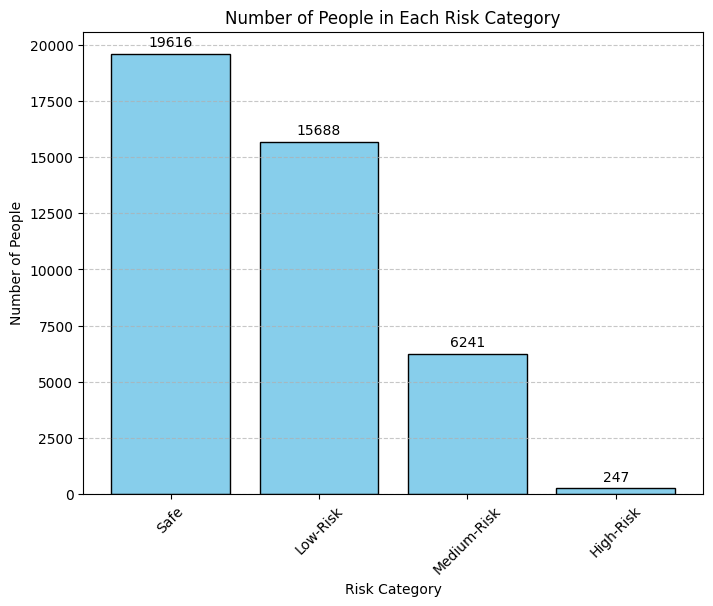

In [12]:
# 1. Define the risk categorization function
def categorize_risk(prob):
    if prob < 0.20:
        return 'Safe'
    elif 0.20 <= prob < 0.60:
        return 'Low-Risk'
    elif 0.60 <= prob < 0.90:
        return 'Medium-Risk'
    else:
        return 'High-Risk'

# 2. Load the submission.csv data
df = pd.read_csv('submission.csv')

# 3. Apply the categorization function to create a new column for risk categories
df['RiskCategory'] = df['predicted_probability'].apply(categorize_risk)

# 4. Count the number of people in each risk category
risk_counts = df['RiskCategory'].value_counts()

# 5. Plot a bar chart of the counts
plt.figure(figsize=(8, 6))
bars = plt.bar(risk_counts.index, risk_counts.values, color='skyblue', edgecolor='black')
plt.title('Number of People in Each Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Number of People')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with counts
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()